计算预测中总是存在不确定性，这可能与观测实例的稀疏性或超参数和模型的选择有关。虽然不可能做出准确的点预测，但我们可以尝试通过减少不确定性来最大限度地降低预测错误率。不确定性量化是一种突出的统计技术，可在模型训练过程中包含不确定性，以便为用户提供更准确、更可靠的输出。

使用 NeuralProphet 默认配置时，会为每个实例预测一个值。预测输出只是一个点估计器，没有考虑任何不确定性。相反，预测区间通过量化每个实例的不确定性和可能的值范围来提供更准确的估计。

在本课程中，我们将向您介绍 NeuralProphet 中可用的两种统计技术：（1） 分位数回归和 （2） 共形预测。这两个模块并不相互排斥，您可以将这两个模块应用到任何模型之上。

我们将使用医院电力负荷数据集来说明并进一步阐述这两个量化模块。该数据集记录了 2015 年旧金山某医院的用电量（按小时计算）。

In [1]:
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level

# 导入依赖
import warnings

warnings.filterwarnings("ignore")

# Disable logging messages unless there is an error
set_log_level("ERROR")

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [2]:
import numpy as np
import pandas as pd
from neuralprophet import (
    NeuralProphet,
    uncertainty_evaluate,
    set_log_level,
    set_random_seed,
)

data_location = "/home/ann/opt/iNeuralProphet/data"
df = pd.read_csv(data_location + "/SF_hospital_load.csv")

In [3]:
m = NeuralProphet()
train_df, test_df = m.split_df(df, freq="H", valid_p=1.0 / 16)

In [4]:
train_df.shape, test_df.shape

((8213, 2), (547, 2))

# 1. 分数位回归

根据 NeuralProphet 预测默认设置，您只能获得一个输出作为每个实例的点估计器。点估计器是根据单个第 50 个百分位回归计算的。要生成预测区间，NeuralProphet 对象需要至少包含一个上限和下限分位数对的列表作为参数。但是，您可以在 NeuralProphet 模型中创建任意数量的分位数

回到预测我们的医院电力负荷数据集。假设我们希望真实值在 90% 的时间内（即 90% 的置信水平）在估计器的预测区间内，我们创建一个三分位数回归模型，分别输出第 5、50 和 95 个百分位值。

In [6]:
# NeuralProphet only accepts quantiles value in between 0 and 1
# Parameter for quantile regression
confidence_lv = 0.9
quantile_list = [
    round(((1 - confidence_lv) / 2), 2),
    round((confidence_lv + (1 - confidence_lv) / 2), 2),
]

# Create NeuralProphet object with list of quantile as parameter
qr_model = NeuralProphet(quantiles=quantile_list)
qr_model.set_plotting_backend("plotly-static")
quantile_list

[0.05, 0.95]

在模型上添加分位数回归模块后，NeuralProphet 会使用弹球损失（分位数损失）函数来评估训练模型的拟合优度。类似于如何将对数似然损失函数用于高斯线性回归。

弹球损失函数不考虑绝对误差，而是对每个不同的分位数具有不同的误差权重。我们通常将超过第 50 个百分位数的上限分位数作为预测区间的上限，将低于第 50 个百分位数的另一个下限分位数作为区间的下限。当实际输出超出预测区间时，损失函数为绝对误差分配更重的权重，反之亦然。我们最终通过迭代调整分位线的参数来最小化损失函数。

让我们看看不同较低分位数（第 10 个百分位数与第 25 个百分位数）之间的权重有何不同。百分位数表示真实值低于估计值的概率。与第 25 个百分位数相比，第 10 个百分位数的真实值低于该线的预期概率较小。当实际值超出预测区间（即实际值小于预测值）时，第 10 个百分位数出现此类误差会成问题更大，因为它预计 90% 的真实值在线上方，而不是第 25 个百分位数的 75% 在线上方。

In [7]:
# Fit the model with the observations
metrics = qr_model.fit(df, freq="H")

# Create a new dataframe for the results
# Including 100 historical values and 30 value points for the future
future = qr_model.make_future_dataframe(df, periods=30, n_historic_predictions=100)

# Perform prediction with the trained models
forecast = qr_model.predict(df=future)

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/248 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

对医院电力负荷的预测如下所示。 yhat1 显示了在第 50 个百分位数所做的预测，而置信区间已以浅蓝色形成。下限是第 10 个分位数的预测结果，而上限是第 90 个分位数的预测结果。

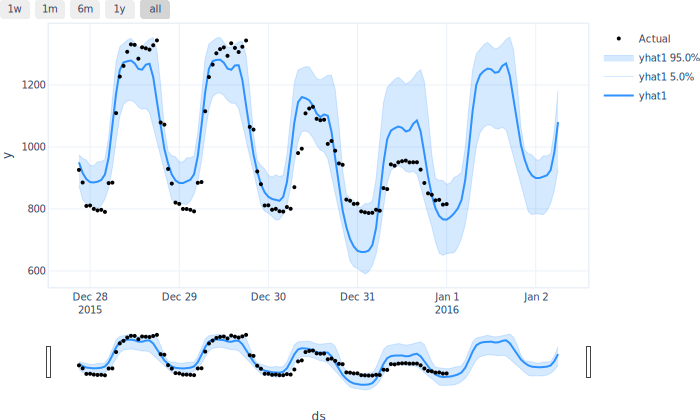

In [8]:
qr_model.plot(forecast)

# 2. 共形预测

虽然有不同的方法可以进行共形预测，但 NeuralProphet 采用了拆分共形预测，这需要一个保留或校准集。为了进行拆分共形预测，必须将数据集分成三个不同的集合，分别进行训练、校准和测试。使用训练数据集训练的基础模型创建初始预测区间。通过将校准集中的目标变量与预测值进行比较来量化不确定性。然后通过将量化的不确定性添加到预测值的两尾来形成最终的共形预测区间。

您可以在 NeuralProphet 中选择朴素（或绝对残差）或共形分位数回归（或 CQR）作为共形预测。我们将在以下小节中详细讨论这两个选项。

进一步将校准集与训练集分开

In [9]:
# Add calibration set using the data splitting function
train_df, cal_df = m.split_df(train_df, freq="H", valid_p=1.0 / 11)

In [10]:
train_df.shape, cal_df.shape, test_df.shape

((7467, 2), (746, 2), (547, 2))

基础模型训练
可以构建任何您认为适合的 NeuralProphet 模型作为基础模型。保形预测中的校准过程稍后将添加到基础模型上，以量化我们最终估计中的不确定性。

回到我们的示例，我们将在此图中比较简单分位数回归和复杂 4 层自回归模型之间的共形预测结果。

In [12]:
# Parameter for autoregression
# Predict the value in the next hours based on the last three daysin an-hour steps
n_lags = 3 * 24

In [13]:
# Create a simple quantile regression model
cp_model1 = NeuralProphet(quantiles=quantile_list)
cp_model1.set_plotting_backend("plotly-static")

# Create a 4-layer autoregression model as the base
cp_model2 = NeuralProphet(
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=n_lags,
    ar_layers=[32, 32, 32, 32],
    learning_rate=0.003,
    quantiles=quantile_list,
)
cp_model2.set_plotting_backend("plotly-static")

In [14]:
# Feed the training subset in the configured NeuralProphet models
# Configure the hourly frequency by assigning 'H' to parameter freq
set_random_seed(0)
metrics1 = cp_model1.fit(train_df, freq="H")
set_random_seed(0)
metrics2 = cp_model2.fit(train_df, freq="H")

Training: |          | 0/? [00:00<?, ?it/s]

Finding best initial lr:   0%|          | 0/246 [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

用拟合基础模型来预测测试数据集的点预测和分位数回归预测区间

In [15]:
forecast1 = cp_model1.predict(test_df)[n_lags:]
forecast2 = cp_model2.predict(test_df)[n_lags:]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

## 2.1 朴素共形预测

训练基础模型后，我们使用 naive 该模块执行校准过程。步骤概述如下：i. 预测校准集中实例的输出值;ii. 通过比较校准集中每个观测值的实际值和预测值来计算绝对残差;iii. 按升序对所有绝对残差进行排序;iv. 找到具有所需置信水平的量化不确定性 v. 使用量化的不确定度输出最终的预测区间。

回到我们的示例，我们需要在上面的预训练模型之上表示校准集的参数值，共形预测的显着水平 （alpha）

In [16]:
method = "naive"
alpha = 1 - confidence_lv

# Enable conformal predict on the pre-trained models
# Evaluate parameter is optional, refer to the "Evaluate Performance" session below
naive_forecast1 = cp_model1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
    show_all_PI=True,
)
naive_forecast2 = cp_model2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
    show_all_PI=True,
)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

上图显示了量化不确定性如何随不同的置信水平1-alpha 而变化。

In [17]:
naive_forecast1

,ds,y,yhat1,yhat1 - qhat1,yhat1 + qhat1,trend,season_weekly,season_daily,yhat1 5.0%,yhat1 95.0%
0,2015-12-09 06:00:00,803.410865,986.211914,826.323425,1146.100342,1030.975952,-36.357544,-8.406522,898.949341,1077.043335
1,2015-12-09 07:00:00,868.264194,1087.415039,927.526550,1247.303467,1030.992188,-44.147156,100.570030,982.120117,1180.354980
2,2015-12-09 08:00:00,975.752982,1146.608521,986.720032,1306.497070,1031.008301,-52.561153,168.161301,1047.781494,1229.768311
3,2015-12-09 09:00:00,983.268943,1155.296997,995.408508,1315.185547,1031.024414,-60.754818,185.027374,1071.773193,1238.744385
4,2015-12-09 10:00:00,1095.825986,1146.330566,986.442078,1306.218994,1031.040649,-69.140640,184.430557,1069.997925,1235.107422
...,...,...,...,...,...,...,...,...,...,...
542,2015-12-31 20:00:00,845.563081,833.305176,673.416687,993.193665,1039.736084,-100.520241,-105.910645,746.842224,931.532349
543,2015-12-31 21:00:00,827.530521,795.605530,635.717041,955.494019,1039.752197,-91.509911,-152.636795,698.650574,884.134399
544,2015-12-31 22:00:00,829.256300,773.339111,613.450623,933.227600,1039.768311,-82.373817,-184.055450,664.933228,884.649902
545,2015-12-31 23:00:00,813.937205,765.239685,605.351196,925.128174,1039.784546,-73.369743,-201.175156,658.067200,880.031372


In [18]:
naive_qhat1 = (
    naive_forecast1.iloc[-1]["yhat1"] - naive_forecast1.iloc[-1]["yhat1 - qhat1"]
)  # cp_model1
naive_qhat2 = (
    naive_forecast2.iloc[-1]["yhat1"] - naive_forecast2.iloc[-1]["yhat1 - qhat1"]
)  # cp_model2
naive_qhat1, naive_qhat2

(159.88849, 29.705383)

使用相同的分位数参数时，与复杂模型相比，简单模型具有更宽的分位数回归预测区间（蓝色）。共形预测区间（红色）也会发生同样的情况，其中较弱的模型具有更宽的宽度，因此它可以捕获比分位数回归预测区间更多的实际值。

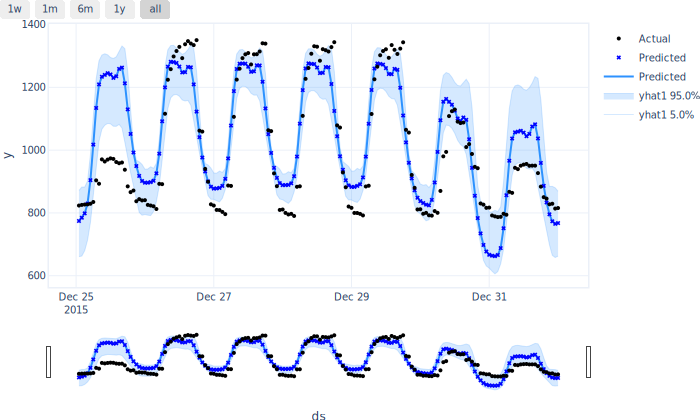

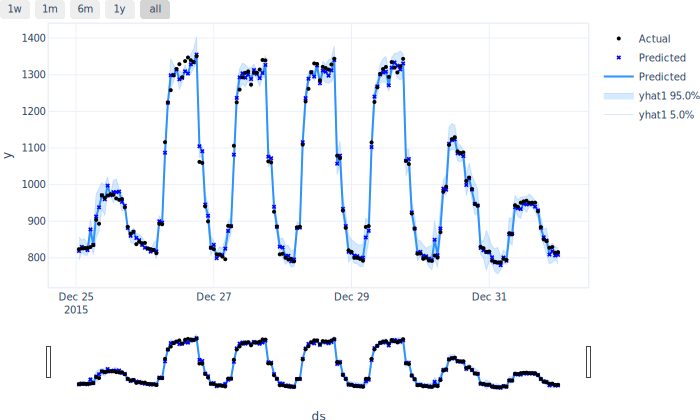

In [19]:
# Date range shown in the plots (optional)
cutoff = 7 * 24

fig1 = cp_model1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast1[-cutoff:], plotting_backend="plotly-static"
)
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    naive_forecast2[-cutoff:], plotting_backend="plotly-static"
)

## 2.2 共形分位数回归

在共形分位数回归模块 cqr 中，该方法按如下方式运行：i. 将不合格分数计算为校准数据集中的数据点与其最近的预测分位数之间的差异，该分位数提供了数据与当前分位数回归模型的拟合程度的度量。对于分位数回归区间内的数据点，不合格分数为负，如果数据点在区间之外，则为正;ii. 不合格分数排序列表;iii. 找到列表中大于该错误率的分数部分的值;和四。将回归模型中的分位数调整一定量。

CQR 模型基于 q 的 值的含义有两种方案。如果单侧预测间隔宽度调整为正，则 CQR 将超出 QR 间隔，因为它认为 QR 间隔过于置信。相反，如果单侧预测区间宽度调整为负，则 CQR 会收缩 QR 区间，因为它认为 QR 区间过于保守。

In [20]:
# Parameter for Conformalized Quantile Regression
method = "cqr"

# Enable conformal predict on the pre-trained models
# Evaluate parameter is optional, refer to the "Evaluate Performance" session below
cqr_forecast1 = cp_model1.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
)
cqr_forecast2 = cp_model2.conformal_predict(
    test_df,
    calibration_df=cal_df,
    alpha=alpha,
    method=method,
    plotting_backend="plotly-static",
)

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

以下是每个模型的 q 值。由于它们都是正的，您会看到 CQR 区间超出了简单 QR 的区间。cp_model1 这两个区间之间的差距很大，因为它的值较大 q  ，而 cp_model2 的边界偏移要小得多。

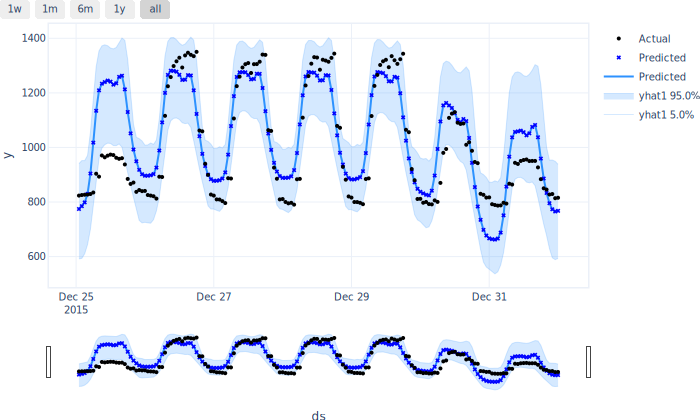

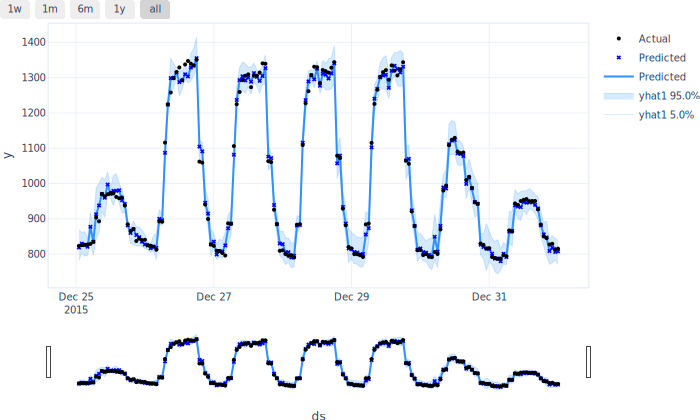

In [21]:
fig1 = cp_model1.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast1[-cutoff:], plotting_backend="plotly-static"
)
fig2 = cp_model2.highlight_nth_step_ahead_of_each_forecast(1).plot(
    cqr_forecast2[-cutoff:], plotting_backend="plotly-static"
)

# 评估性能

我们使用区间宽度和误覆盖率作为性能指标。
- interval_width ：平均预测区间，或 q_hat 乘以 2，因为它是静态的或非自适应的，这也称为效率指标。
- miscoverage_rate ：OOS 测试集上的实际误覆盖错误率，这也称为有效性指标。
指标越小，模型的性能就越好。

让我们使用上面训练的模型进行测试。我们首先为训练的两个模型构建一个包含两行的数据框，然后我们将连接数据框中的 Naive 和 CQR 性能指标以进行评估。

In [22]:
# Create evaluation dataframe skeleton with the 2 models (denoted as m1 and m2)
models = ["m1", "m2"]
eval_df = pd.DataFrame(models, columns=pd.MultiIndex.from_tuples([("model", "", "")]))

我们将在本次实验中聚合 naïve 的性能指标，并将它们放入评估数据帧骨架中。在共形预测功能中启用 evaluate 参数时，将计算性能指标。

In [23]:
# Extract the naive performance metrics from their respective forecast datasets
naive_eval1 = uncertainty_evaluate(naive_forecast1)
naive_eval2 = uncertainty_evaluate(naive_forecast2)

# Aggregate the naive performance metrics for m1 and m2
naive_evals = [naive_eval1, naive_eval2]
naive_eval_df = pd.concat(naive_evals).reset_index(drop=True)

In [24]:
# Extract the cqr performance metrics from their respective forecast datasets
cqr_eval1 = uncertainty_evaluate(cqr_forecast1)
cqr_eval2 = uncertainty_evaluate(cqr_forecast2)

# Aggregate the cqr performance metrics for m1 and m2
cqr_evals = [cqr_eval1, cqr_eval2]
cqr_eval_df = pd.concat(cqr_evals).reset_index(drop=True)

后，我们将朴素和 cqr 评估数据框连接起来，然后将朴素和 cqr 预测的模型性能进行比较。

In [25]:
# Concatenate the naive and cqr evaluation dataframes
eval_df = pd.concat([naive_eval_df, cqr_eval_df], axis=1, keys=["naive", "cqr"])
eval_df

naive                             cqr                 
           yhat1                           yhat1                 
  interval_width miscoverage_rate interval_width miscoverage_rate
0     319.777100         0.109689     306.757996         0.104205
1      59.410828         0.050526      73.659119         0.035789